# Install useful libraries

Here we install usefuls libraries for language processing.

In [85]:
! pip install nltk==3.6.7 # Nltk is a simple but useful library for nlp

# Required Libraries

Here we export the required python libraries.

In [211]:
import os # Check gile existance
import urllib.request # Download files from the web
from bs4 import BeautifulSoup # Parse html files
import unicodedata # Normalize text
import re # Find regular expresions
import nltk # Natural Language Processing
import pandas as pd # Organize data in dataframes
import matplotlib.pyplot as plt
import numpy as np

# Misc Functions

Miscelanious functions that will be used during the text processing

In [46]:
# Take a text and remove any accents
def remove_accents(text):
    normalized_text = unicodedata.normalize('NFD', text) # Untangle lettre and accent characters
    non_accented_text = re.sub('[\u0300-\u036f]', '', normalized_text) # Removve accent characters
    return non_accented_text

# Data

## Misc Data

In [ ]:
We download a punctuation file to preprocess text.

In [88]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Get a local version if not present

If we do not have a local version of the html file that contains the play, we will download one.

In [5]:
data_url = 'http://dramacode.github.io/html/moliere_avare.html' 
data_file = 'moliere_avare.html'
if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

## Load the data

Now that we know there is a local version of the html file we can parse it with BeautifulSoup so it is easy to explore the document.

In [9]:
with open('moliere_avare.html', 'rb') as file:
    soup = BeautifulSoup(file, 'html.parser')

# Characters Analysis

## Collect list of characters

Now we can extract all the characters from the document

In [72]:
characters = [char for char in soup.find_all('li', {'class':'castItem'})] # Get characters from the cast list
characters = [char.find('span').get('id') for char in characters] # Extract id from character
characters = [char.replace('-',' ') for char in characters] # Clean character id
characters

['harpagon',
 'cleante',
 'elise',
 'valere',
 'mariane',
 'anselme',
 'frosine',
 'maitre simon',
 'maitre jacques',
 'la fleche',
 'dame claude',
 'brindavoine',
 'la merluche',
 'commissaire']

## Collect characters' speech

Now that we have a list of characters, we can go over the play and collect the speech of each character.

In [169]:
# Dictionary to collect all the speech data
speech_dict = {
    'act':[],
    'scene':[], 
    'speaker':[],
    'speech':[]
}

# Get the body of the page
body = soup.find('section', {'class':'body'})

# Get all the acts
for act_body in body.find_all('section', {'class':'level2'}):
    act = act_body.get('id')
    # Get all the scenes of the act
    for scene_body in act_body.find_all('section', {'class':'level3'}):
        scene = scene_body.get('id')
        # Get the speakers and speeches of the scene
        for speech_body in scene_body.find_all('div', {'class':'sp'}):
            speaker = speech_body.find('p', {'class':'speaker'}).text
            # Clean t he speakers name
            speaker = remove_accents(speaker).lower()
            
            # Map the given speaker to known characters
            for char in characters:
                if char in speaker:
                    speaker = char
                    break
            
            speech = speech_body.find('p', {'class':'p autofirst'}).text.strip()
            # Split speech into sentences
            speech = nltk.tokenize.sent_tokenize(speech, language='french')
            speech = [nltk.tokenize.word_tokenize(sent, language='french') for sent in speech]
            # Split sentences into tokens
            
            # Add the data to the Dictionary
            speech_dict['act'].append(act)
            speech_dict['scene'].append(scene)
            speech_dict['speaker'].append(speaker)
            speech_dict['speech'].append(speech)
            
speech_df = pd.DataFrame(speech_dict)
speech_df.head()

act scene speaker                                             speech
0   I   I01  valere  [[Hé, quoi, ,, charmante, Élise, ,, vous, deve...
1   I   I01   elise  [[Non, ,, Valère, ,, je, ne, puis, pas, me, re...
2   I   I01  valere  [[Hé, que, pouvez-vous, craindre, ,, Élise, ,,...
3   I   I01   elise  [[Hélas, !], [cent, choses, à, la, fois, :, L'...
4   I   I01  valere  [[Ah, !], [ne, me, faites, pas, ce, tort, ,, d...

## Compute characters' statistics

First we compute some basic statistics from the existing dataset

In [170]:
# Count total sentences on each characters' line
speech_df['sentences'] = speech_df.speech.apply(len)
# Count total tokens on each characters' line
speech_df['tokens'] = speech_df.speech.apply(lambda speech:sum([len(sent) for sent in speech]))
speech_df.head()

act scene speaker                                             speech  \
0   I   I01  valere  [[Hé, quoi, ,, charmante, Élise, ,, vous, deve...   
1   I   I01   elise  [[Non, ,, Valère, ,, je, ne, puis, pas, me, re...   
2   I   I01  valere  [[Hé, que, pouvez-vous, craindre, ,, Élise, ,,...   
3   I   I01   elise  [[Hélas, !], [cent, choses, à, la, fois, :, L'...   
4   I   I01  valere  [[Ah, !], [ne, me, faites, pas, ce, tort, ,, d...   

   sentences  tokens  
0          4      65  
1          3      76  
2          1      16  
3          2      56  
4          4      53

Then we can get overall values for each character

In [171]:
# Get the total score for each character
ammount_of_speech = speech_df[['speaker', 'sentences', 'tokens']].groupby('speaker').sum()
ammount_of_speech['lines'] = speech_df.speaker.value_counts()
# Sort the characters from more tokens spoken to least tokens spoken
ammount_of_speech = ammount_of_speech.sort_values('tokens', ascending=False)
ammount_of_speech

sentences  tokens  lines
speaker                                 
harpagon              545    6180    355
cleante               234    3670    161
valere                160    2943    100
frosine               138    2360     59
maitre jacques        127    1739     85
la fleche             104    1684     66
elise                  71    1179     51
mariane                53    1009     32
anselme                34     570     20
commissaire            29     328     17
maitre simon           10     221      5
la merluche             5      51      5
brindavoine             3      44      3

Based on this data the answer to **Which character speaks the most?** is *Harpagon*

The answer to **Which one does not speak at all?** we can fidn which characters dont have any line recorded:

In [141]:
for char in characters:
    if char not in speech_df.speaker.unique():
        print(char)

dame claude


Based on this, *Dame Claude* does not speak at all.

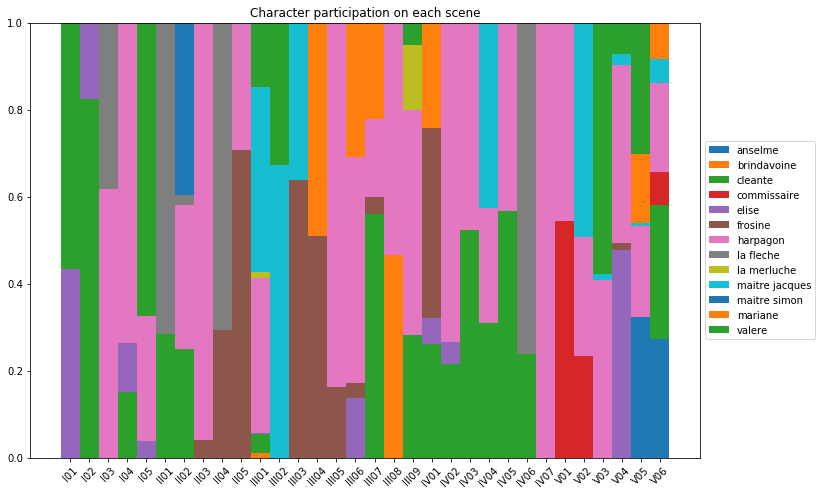

In [233]:
granular_ammount_of_speech = speech_df[['scene', 'speaker', 'tokens']].groupby(['scene', 'speaker']).sum()
granular_ammount_of_speech = granular_ammount_of_speech/granular_ammount_of_speech.groupby(level=0).transform('sum')

scenes = granular_ammount_of_speech.index.levels[0]
tokens = {
    char:[granular_ammount_of_speech.loc[scene, char].tokens if granular_ammount_of_speech.index.isin([(scene, char)]).any() else 0 for scene in scenes]
    for char in granular_ammount_of_speech.index.levels[1]
}
width = 1
tokens

fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(len(scenes))

for boolean, tokens in tokens.items():
    p = ax.bar(scenes, tokens, width, label=boolean, bottom=bottom)
    bottom += tokens

ax.set_title("Character participation on each scene")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation = 45) 

plt.show()